<a href="https://colab.research.google.com/github/fagonzalezo/qmc/blob/master/examples/qmkde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install qmc if running in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !rm -R qmc qmc1
    !git clone https://github.com/fagonzalezo/qmc.git
    !mv qmc qmc1
    !mv qmc1/qmc .
else:
    import sys
    sys.path.insert(0, "../")

In [2]:
%matplotlib inline
import numpy as np
import pylab as pl

# Function to visualize a 2D dataset
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Function to visualize the decission surface of a classifier
def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 50)
    y_vals = np.linspace(min_y, max_y, 50)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    vals = [[XX[i, j], YY[i, j]] for i in range(grid_r) for j in range(grid_c)]
    preds = pred_fun(np.array(vals))
    ZZ = np.reshape(preds, (grid_r, grid_c))
    print(np.min(preds), np.min(ZZ))
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    CS = pl.contour(XX, YY, ZZ, 100, levels = [0.1*i for i in range(1,10)])
    pl.clabel(CS, inline=1, fontsize=10)
    pl.xlabel("x")
    pl.ylabel("y")

def gen_pred_fun(clf):
    def pred_fun(X):
        return clf.predict(X)[:, 1]
    return pred_fun

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import qmc.tf.layers as layers
import qmc.tf.models as models


(100, 2)


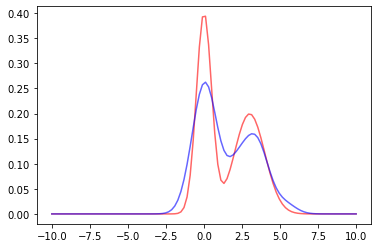

In [111]:
from scipy.stats import norm, bernoulli, gaussian_kde

class Mixture(object):

    def __init__(self, loc1=0, scale1=1, loc2=1, scale2=1, alpha=0.5):
        self.var1 = norm(loc=loc1, scale=scale1)
        self.var2 = norm(loc=loc2, scale=scale2)
        self.alpha = alpha
        
    def pdf(self, x):
        return (self.alpha * self.var1.pdf(x) + 
                (1 - self.alpha) * self.var2.pdf(x))

    def rvs(self, size=1):
        vals = np.stack([self.var1.rvs(size), self.var2.rvs(size)],  axis=-1)
        print(vals.shape)
        idx = bernoulli.rvs(1. - self.alpha, size=size)
        return np.array([vals[i, idx[i]] for i in range(size)])

n_var = norm(loc=1, scale=1)
mixt = Mixture(loc1=0, scale1=0.5, loc2=3, scale2=1, alpha=0.5)
sample = mixt.rvs(100)
kernel = gaussian_kde(sample)
x = np.linspace(-10.,10.,100)
pl.plot(x, mixt.pdf(x), 'r-',  alpha=0.6, label='norm pdf')
pl.plot(x, kernel(x), 'b-',  alpha=0.6, label='kde pdf')


4/4 [==============================] - 0s 3ms/step


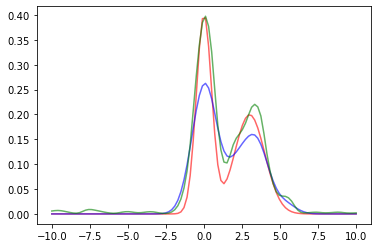

In [123]:
X = sample.reshape((-1, 1))
dim = 300
fm_x = layers.QFeatureMapRFF(1, dim=dim, gamma=1, random_state=17)
qmd = models.QMDensity(fm_x, dim)
qmd.compile()
qmd.fit(X, epochs=1)
out = qmd.predict(x.reshape((-1, 1)))
pl.plot(x, mixt.pdf(x), 'r-',  alpha=0.6, label='norm pdf')
pl.plot(x, kernel(x), 'b-',  alpha=0.6, label='kde pdf')
pl.plot(x, out, 'g-',  alpha=0.6, label='qmkde pdf')


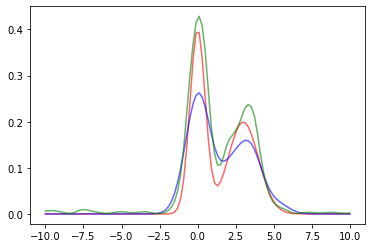

In [127]:
qmd1 = models.QMDensitySGD(1, dim, num_eig=5, gamma=1, random_state=17)
eig_vals = qmd1.set_rho(qmd.weights[2])
out = qmd1.predict(x.reshape((-1, 1)))
pl.plot(x, mixt.pdf(x), 'r-',  alpha=0.6, label='norm pdf')
pl.plot(x, kernel(x), 'b-',  alpha=0.6, label='kde pdf')
pl.plot(x, out, 'g-',  alpha=0.6, label='qmkde pdf')

<tf.Tensor: shape=(), dtype=float32, numpy=1.0000007>

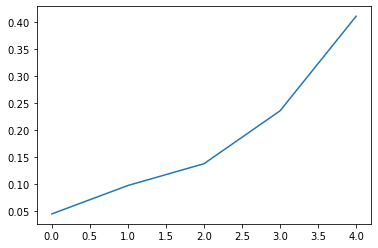

In [126]:
pl.plot(eig_vals[-5:])
tf.reduce_sum(eig_vals)

Epoch 1/20
4/4 [==============================] - 0s 30ms/step - loss: 133.7121
Epoch 2/20
4/4 [==============================] - 0s 47ms/step - loss: 85.7930
Epoch 3/20
4/4 [==============================] - 0s 31ms/step - loss: 70.6353
Epoch 4/20
4/4 [==============================] - 0s 34ms/step - loss: 62.1687
Epoch 5/20
4/4 [==============================] - 0s 30ms/step - loss: 56.7719
Epoch 6/20
4/4 [==============================] - 0s 29ms/step - loss: 52.9523
Epoch 7/20
4/4 [==============================] - 0s 29ms/step - loss: 50.1843
Epoch 8/20
4/4 [==============================] - 0s 35ms/step - loss: 48.0542
Epoch 9/20
4/4 [==============================] - 0s 34ms/step - loss: 46.3694
Epoch 10/20
4/4 [==============================] - 0s 52ms/step - loss: 45.0093
Epoch 11/20
4/4 [==============================] - 0s 49ms/step - loss: 43.8978
Epoch 12/20
4/4 [==============================] - 0s 49ms/step - loss: 42.9843
Epoch 13/20
4/4 [==============================]

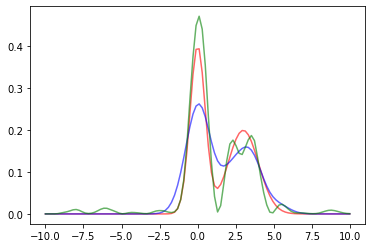

In [130]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
qmd3 = models.QMDensitySGD(1, dim, num_eig=4, gamma=1.5, random_state=17)
qmd3.layers[1].trainable = True
qmd3.layers[0].trainable = False
qmd3.compile(optimizer)
#eig_vals = qmd3.set_rho(qmd.weights[2])
qmd3.fit(X, epochs=20)
out = qmd3.predict(x.reshape((-1, 1)))
pl.plot(x, mixt.pdf(x), 'r-',  alpha=0.6, label='norm pdf')
pl.plot(x, kernel(x), 'b-',  alpha=0.6, label='kde pdf')
pl.plot(x, out, 'g-',  alpha=0.6, label='qmkde pdf')

In [92]:
qmd3.layers[0].trainable

True